# Using ModelBuilder class for deploying PyMC models 
::: {post} Sep 12, 2022 :tags: model builder class, model class, linear model :category: Beginner :author: Shashank Kirtania, Thomas Wiecki:::

##### Motivation

Many users using PyMC face difficulty in deploying or saving their designed PyMC model because deploying/saving/loading a user-created model is a cumbersome task in PyMC. One of the reasons behind this is there is no direct way to save or load a model in PyMC like scikit-learn or TensorFlow. To combat this, We created a `ModelBuilder` class to improve workflow and use direct APIs to build, fit, save, load, predict and more.

The new `ModelBuilder` class allows users to use direct methods to `fit`, `predict`, `save`, `load`. Users can create any model they want, inherit the `ModelBuilder` class, and use predefined methods. <br>
Let's learn more about using an example <br>

First, we import libraries. We need to deploy a model

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

Now we import the `ModelBuilder` present in the model_builder.py file

In [3]:
from pymc_experimental.model_builder import ModelBuilder

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

To define our desired model we inherit the `ModelBuilder` class to our new model class, here a Linear regression model. We can also define it locally in some other python file and directly import it to our notebook

In [5]:
class LinearModel(ModelBuilder):
    _model_type = "LinearModel"
    version = "0.1"

    @classmethod
    def build_model(self, model_config, data=None):
        if data is not None:
            x = pm.MutableData("x", data["input"].values)
            y_data = pm.MutableData("y_data", data["output"].values)

        # prior parameters
        a_loc = model_config["a_loc"]
        a_scale = model_config["a_scale"]
        b_loc = model_config["b_loc"]
        b_scale = model_config["b_scale"]
        obs_error = model_config["obs_error"]

        # priors
        a = pm.Normal("a", a_loc, sigma=a_scale)
        b = pm.Normal("b", b_loc, sigma=b_scale)
        obs_error = pm.HalfNormal("σ_model_fmc", obs_error)

        # observed data
        if data is not None:
            y_model = pm.Normal("y_model", a + b * x, obs_error, shape=x.shape, observed=y_data)

    def _data_setter(self, data: pd.DataFrame):
        with self.model:
            pm.set_data({"x": data["input"].values})
            if "output" in data.columns:
                pm.set_data({"y_data": data["output"].values})

    @classmethod
    def create_sample_input(cls):
        x = np.linspace(start=0, stop=1, num=100)
        y = 5 * x + 3
        y = y + np.random.normal(0, 1, len(x))
        data = pd.DataFrame({"input": x, "output": y})

        model_config = {
            "a_loc": 0,
            "a_scale": 10,
            "b_loc": 0,
            "b_scale": 10,
            "obs_error": 2,
        }

        sampler_config = {
            "draws": 1_000,
            "tune": 1_000,
            "chains": 3,
            "target_accept": 0.95,
        }

        return data, model_config, sampler_config

Now we can create an object of LinearModel type, which we can edit according to our use or use the default model as defined by the user.
Most importantly, if you make _ a really cool model_ and want to deploy the same, it will be easier for you to make a class and share the model so people can use it via the object instead of redefining the model every time they need it. <br>

Making the object is the same as making an object of a python class. We first define parameters we need to make the object like -> data, model configuration and sampler configuration. 
We can do that using the `create_sample_input()` method described above.

In [6]:
data, model_config, sampler_config = LinearModel.create_sample_input()
model = LinearModel(model_config, sampler_config, data)

After making the object of class `LinearModel` we can fit the model using the `.fit()` method.

`fit` method takes one argument `data` on which we need to fit the model and assigns `idata.attrs` with `id`, `model_type`, `version`, `sample_conifg`, `model_config`. 
* `id` : This is a unique id given to a model based on model_config, sample_conifg, version, and model_type. Users can use it to check if the model matches to another model they have defined.
* `model_type` : Model type tells us what kind of model it is. This in this case it outputs **Linear Model** 
* `version` : In case users want to improvise on models, they can keep track of model by its version. As the version changes the unique hash in the `id` also changes.
* `sample_conifg` : It stores values of the sampler configuration set by user for this particular model.
* `model_config` : It stores values of the model configuration set by user for this particular model.

In [7]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [a, b, σ_model_fmc]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 30 seconds.


After fitting the model, we can probably save it to share the model as a file so one can use it again.
To `save` or `load`, we can quickly call methods for respective tasks with the following syntax.

In [8]:
fname = "./mymodel.nc"
model.save(fname)

This saves a file at the given path, and the name <br>
A `.nc` file that stores the inference data of the model.

Now we create a new model named `model_2` which is same as `model` but instead of fitting it we load it's idata.

In [9]:
data, model_config, sampler_config = LinearModel.create_sample_input()
model_2 = LinearModel(model_config, sampler_config, data)
# loading
new_idata = LinearModel.load(fname)
model_2.idata = new_idata

The `predict()` method allows users to do a posterior predcit with the fitted model on new data.<br>
Our first task is to create data on which we need to predict.

In [10]:
x_pred = np.random.uniform(low=0, high=1, size=100)
prediction_data = pd.DataFrame({"input": x_pred})

Now we predict with `model_2` and save the mean and samples in `pred_mean` and `pred_samples` respectively

In [11]:
pred_mean = model_2.predict(prediction_data)
# samples
pred_samples = model_2.predict(prediction_data, point_estimate=False)

After using the `predict()`, we can plot our data and see graphically how satisfactory our `LinearModel` is

For which we plot our results

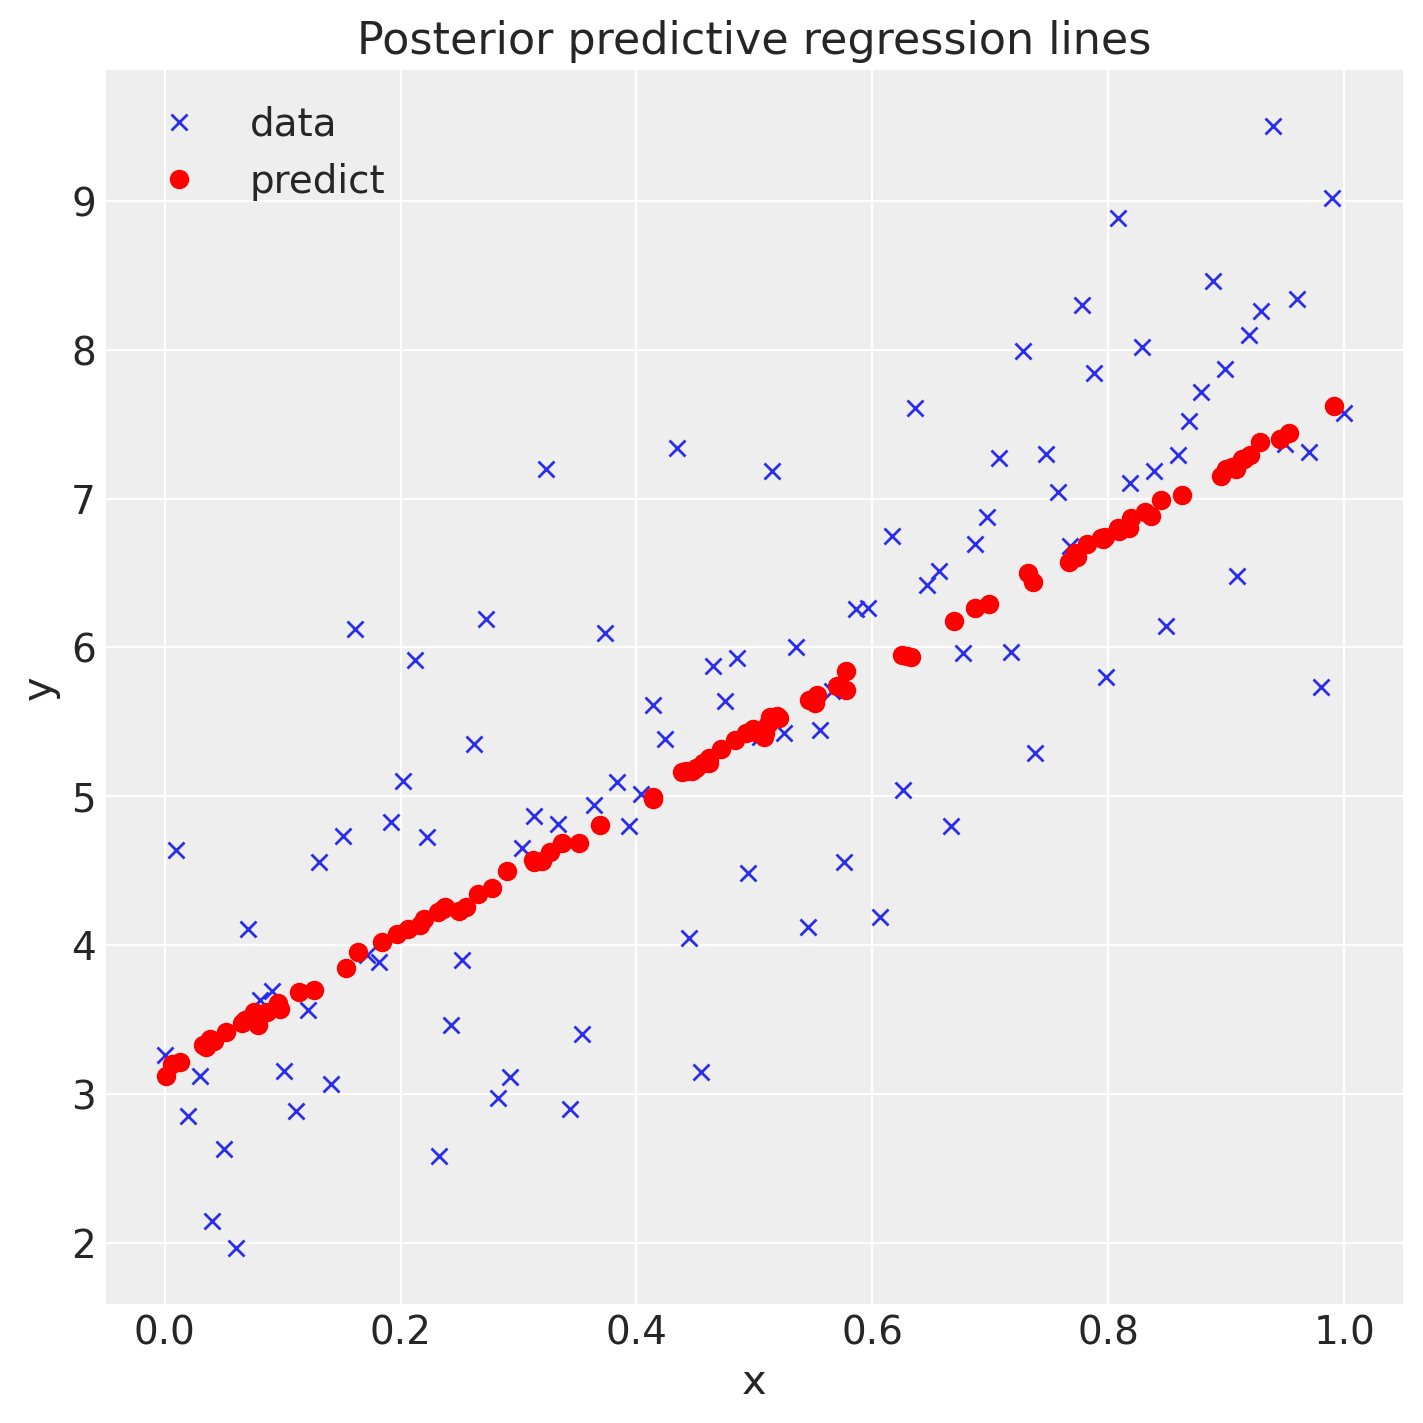

In [12]:
plt.figure(figsize=(7, 7))
plt.plot(data["input"], data["output"], "x", label="data")
plt.plot(prediction_data.input, pred_mean["y_model"], "bo", label="predict", color="r")
plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Sep 17 2022

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.26.0

arviz     : 0.12.1
pandas    : 1.2.4
numpy     : 1.21.6
pymc      : 4.1.7
matplotlib: 3.3.4

Watermark: 2.3.1

